# DATA PREPARATION AND DATA PRE-PROCESSING

IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import cv2
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.utils import class_weight  
import matplotlib.pyplot as plt

2024-09-17 18:18:35.846585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 18:18:35.856495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 18:18:35.859554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 18:18:35.868333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 18:18:36.836871: W tensorflow/compiler/tf2

In [2]:
# Print versions to ensure compatibility
print("TensorFlow version:", tf.__version__)
print("CUDA version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN version:", tf.sysconfig.get_build_info()['cudnn_version'])
!python3 --version

TensorFlow version: 2.17.0
CUDA version: 12.3
cuDNN version: 8
Python 3.10.12


DATASET LOADING

In [3]:
import subprocess

# Convert the Windows path to WSL path using subprocess
def windows_to_wsl_path(windows_path):
    return subprocess.check_output(['wslpath', windows_path]).decode('utf-8').strip()

# Define the base path to the dataset (Windows path)
windows_base_path = r'C:\Users\arock\Downloads\Pomegranate Fruit Diseases Dataset for Deep Learning Models'
# Convert the base path to WSL path

base_path = windows_to_wsl_path(windows_base_path)

# Define categories (classes) in the dataset
categories = ['Alternaria', 'Anthracnose', 'Bacterial_Blight', 'Cercospora', 'Healthy']

# Batch size (still needed to control how many images are processed at once)
BATCH_SIZE = 8

DISPLAYING THE SAMPLES OF THE ORIGINAL DATASET

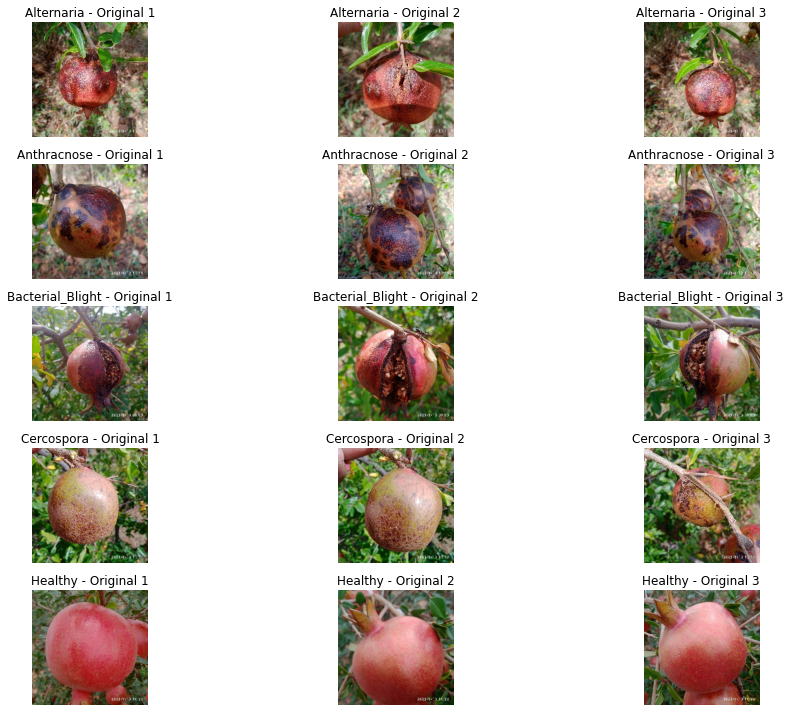

In [4]:
# Display sample images from each class before resizing
def display_sample_images_before_resizing(base_path, categories, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, 'train', category)
        images = os.listdir(category_path)
        
        for j in range(num_samples):
            img_path = os.path.join(category_path, images[j])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
            
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(img_rgb)
            plt.title(f'{category} - Original {j + 1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the original sample images before resizing
display_sample_images_before_resizing(base_path, categories)

VERIFYING THE SPLIT

In [5]:
# Verify the split
def verify_dataset_split(base_path, categories):
    total_count = 0
    for split in ['train', 'val', 'test']:
        split_count = 0
        for category in categories:
            path = os.path.join(base_path, split, category)
            count = len(os.listdir(path))
            split_count += count
            print(f"{split.capitalize()} - {category}: {count} images")
        print(f"Total in {split}: {split_count} images")
        total_count += split_count
    print(f"Overall total images: {total_count}")

# Check the dataset split for train, val, and test
verify_dataset_split(base_path, categories)

Train - Alternaria: 620 images
Train - Anthracnose: 816 images
Train - Bacterial_Blight: 676 images
Train - Cercospora: 441 images
Train - Healthy: 1014 images
Total in train: 3567 images
Val - Alternaria: 132 images
Val - Anthracnose: 174 images
Val - Bacterial_Blight: 144 images
Val - Cercospora: 94 images
Val - Healthy: 217 images
Total in val: 761 images
Test - Alternaria: 134 images
Test - Anthracnose: 176 images
Test - Bacterial_Blight: 146 images
Test - Cercospora: 96 images
Test - Healthy: 219 images
Total in test: 771 images
Overall total images: 5099


CUSTOM IMAGE AUGMENTATION FUNCTIONS

In [6]:
# Custom function for edge detection
def add_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels
    return cv2.addWeighted(image, 0.8, edges, 0.2, 0)  # Blend the edge image with the original

# Custom function for luminosity adjustment
def adjust_luminosity(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Custom function for color jittering
def color_jitter(image, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float64)
    img[..., 1] *= (1 + saturation * (np.random.random() - 0.5))
    img[..., 0] += hue * (np.random.random() - 0.5) * 180
    img[..., 2] *= (1 + brightness * (np.random.random() - 0.5))
    img[..., 2] *= contrast
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

DATA GENERATORS WITH CUSTOM AUGMENTATION

In [7]:
# Custom augmentation function
def custom_augmentation(image):
    image = add_edge_detection(image)
    image = adjust_luminosity(image, alpha=np.random.uniform(0.8, 1.2), beta=np.random.uniform(-10, 10))
    image = color_jitter(image)
    return image

# Custom ImageDataGenerator with augmentation
class CustomImageDataGenerator(ImageDataGenerator):
    def random_transform(self, x, seed=None):
        x = super().random_transform(x, seed)
        x = custom_augmentation(x)
        return x

# Data augmentation with custom generator for training set
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Validation and test data generator (no augmentation, only normalization)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define the output shapes (images of size 224x224x3 and one-hot encoded labels with 4 classes)
batch_shape = (None, 224, 224, 3)  # Include batch dimension
label_shape = (None, len(categories))

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    ),
    output_signature=(
        tf.TensorSpec(shape=batch_shape, dtype=tf.float32),
        tf.TensorSpec(shape=label_shape, dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_test_datagen.flow_from_directory(
        os.path.join(base_path, 'val'),
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    ),
    output_signature=(
        tf.TensorSpec(shape=batch_shape, dtype=tf.float32),
        tf.TensorSpec(shape=label_shape, dtype=tf.float32)
    )
)


# Prefetch for faster data loading
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

I0000 00:00:1726577326.041435    4874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726577326.084814    4874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726577326.084911    4874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726577326.090532    4874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726577326.090623    4874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

NUMBER OF TRAINING, VALIDATION AND TEST SAMPLES

In [8]:
# Specify the number of samples in train, val, and test datasets
train_samples = 3567  # Manually specify the number of training samples
val_samples = 761  # Manually specify the number of validation samples

# Adjust steps calculation to use np.ceil() to account for incomplete batches
steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))
validation_steps = int(np.ceil(val_samples / BATCH_SIZE))

# MODEL TRAINING

MODEL FUNCTION CREATION

In [9]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

# Load EfficientNetV2B0 with pre-trained weights and exclude the top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = True

# Add global average pooling layer to reduce dimensionality
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer for classification
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)  # Increased dropout for regularization

x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)  # Increased dropout for regularization

classification_output = Dense(len(categories), activation='softmax', name='classification_output')(x)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


MODEL SETUP AND COMPILATION

In [10]:
# Combine the base model and classification head into a single model
model = Model(inputs=base_model.input, outputs=classification_output)

# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Compute class weights to handle class imbalance
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

'''
class_weights = {0: 1.1506451612903226, 
                 1: 0.8742647058823529, 
                 2: 1.0553254437869823, 
                 3: 1.617687074829932, 
                 4: 0.7035502958579881}
'''
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

Found 3567 images belonging to 5 classes.
Class Weights: {0: 1.1506451612903226, 1: 0.8742647058823529, 2: 1.0553254437869823, 3: 1.617687074829932, 4: 0.7035502958579881}


In [11]:
# Display the model summary to understand its structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,707,797 (25.59 MB)

 Trainable params: 6,647,189 (25.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

DENSENET121 MODEL TRAINING AND CALLBACKS

In [13]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define early stopping and model checkpoint callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('best_efficientnet_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# Define learning rate reduction callback
lr_reduction_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Train DenseNet121 model
print(f"\nStarting training for EfficientNetV2B0 model...")
start_time = time.time()

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=60,
    class_weight=class_weights_dict,  # Add class weights to handle class imbalance
    callbacks=[early_stopping_callback, checkpoint_callback, lr_reduction_callback]
)

training_time = time.time() - start_time


Starting training for EfficientNetV2B0 model...
Epoch 1/60
Found 3567 images belonging to 5 classes.


I0000 00:00:1726577402.193876    5031 service.cc:146] XLA service 0x7fbc88001f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726577402.193910    5031 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-17 18:20:03.348016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-17 18:20:06.781948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-17 18:20:11.170579: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23265', 8 bytes spill stores, 8 bytes spill loads

2024-09-17 18:20:47.127255: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory

445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2768 - loss: 2.6345 - precision: 0.2072 - recall: 3.9043e-04

2024-09-17 18:21:29.797370: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23265', 4 bytes spill stores, 4 bytes spill loads

2024-09-17 18:22:08.237824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 148 bytes spill stores, 148 bytes spill loads



446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2770 - loss: 2.6344 - precision: 0.2088 - recall: 4.0213e-04Found 761 images belonging to 5 classes.


2024-09-17 18:22:11.312899: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2366', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 2.30022, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 166s 222ms/step - accuracy: 0.2773 - loss: 2.6342 - precision: 0.2103 - recall: 4.1377e-04 - val_accuracy: 0.7740 - val_loss: 2.3002 - val_precision: 1.0000 - val_recall: 0.0145 - learning_rate: 1.0000e-05
Epoch 2/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7104 - loss: 2.1710 - precision: 0.9555 - recall: 0.1874
Epoch 2: val_loss improved from 2.30022 to 1.60446, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.7105 - loss: 2.1707 - precision: 0.9555 - recall: 0.1877 - val_accuracy: 0.9093 - val_loss: 1.6045 - val_precision: 0.9689 - val_recall: 0.7372 - learning_rate: 1.0000e-05
Epoch 3/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8426 - loss: 1.6555 - precision: 0.9096 - recall: 0.7204
Epoch 3: val_loss improved from 1.60446 to 1.36199, saving model to best_efficientnet_model.ker

Epoch 33/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9798 - loss: 0.8577 - precision: 0.9827 - recall: 0.9782
Epoch 33: val_loss improved from 0.82677 to 0.82594, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.9798 - loss: 0.8577 - precision: 0.9827 - recall: 0.9782 - val_accuracy: 0.9803 - val_loss: 0.8259 - val_precision: 0.9803 - val_recall: 0.9803 - learning_rate: 1.0000e-05
Epoch 34/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9766 - loss: 0.8424 - precision: 0.9795 - recall: 0.9755
Epoch 34: val_loss improved from 0.82594 to 0.81040, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.9766 - loss: 0.8424 - precision: 0.9795 - recall: 0.9755 - val_accuracy: 0.9816 - val_loss: 0.8104 - val_precision: 0.9816 - val_recall: 0.9816 - learning_rate: 1.0000e-05
Epoch 35/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9802 - loss: 0.8410 - prec

Epoch 49/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9850 - loss: 0.6883 - precision: 0.9870 - recall: 0.9842
Epoch 49: val_loss improved from 0.67374 to 0.66624, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9850 - loss: 0.6883 - precision: 0.9870 - recall: 0.9842 - val_accuracy: 0.9855 - val_loss: 0.6662 - val_precision: 0.9855 - val_recall: 0.9855 - learning_rate: 1.0000e-05
Epoch 50/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9866 - loss: 0.6646 - precision: 0.9889 - recall: 0.9866
Epoch 50: val_loss improved from 0.66624 to 0.65131, saving model to best_efficientnet_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.9866 - loss: 0.6646 - precision: 0.9889 - recall: 0.9866 - val_accuracy: 0.9869 - val_loss: 0.6513 - val_precision: 0.9869 - val_recall: 0.9869 - learning_rate: 1.0000e-05
Epoch 51/60
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9895 - loss: 0.6516 - prec

TOTAL TRAINING TIME

In [14]:
print(f'EfficientNetV2B0 Training time: {training_time:.2f} seconds')

EfficientNetV2B0 Training time: 2916.35 seconds


# EVALUATION METRICS

EVALUATION OF MODELS

MODEL PERFORMANCE VISUALIZATION

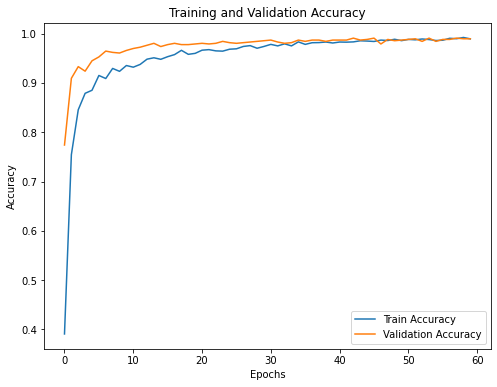

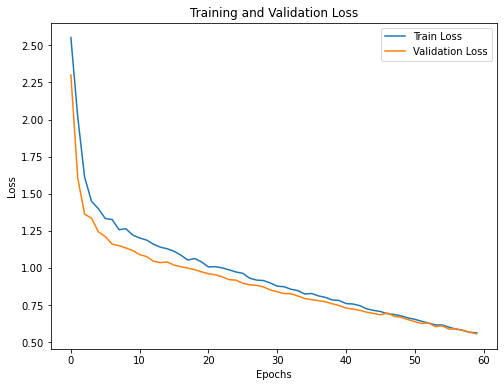

In [16]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot((history.history['accuracy']), label='Train Accuracy')
plt.plot((history.history['val_accuracy']), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot smoothed training and validation loss
plt.figure(figsize=(8, 6))
plt.plot((history.history['loss']), label='Train Loss')
plt.plot((history.history['val_loss']), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

SEPERATE ImageDataGenerator

In [17]:
# Define a separate ImageDataGenerator for the test set without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory for the test set
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Make sure this is set to 'categorical' to match your model
    shuffle=False  # Important: shuffle should be False for test set
)

Found 771 images belonging to 5 classes.


In [18]:
test_samples = 771 # Manually specify number of test samples

In [19]:
test_steps = int(np.ceil(test_samples / BATCH_SIZE))

In [21]:
# Evaluate the trained model using the test data generator
results = model.evaluate(test_generator, steps=test_steps)

# Assuming you have 4 metrics: loss, accuracy, precision, and recall
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9670 - loss: 0.6266 - precision: 0.9670 - recall: 0.9670
Test Loss: 0.5711
Test Accuracy: 0.9844
Test Precision: 0.9844
Test Recall: 0.9844


CONFUSION MATRIX

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Calculate the number of steps as an integer
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Evaluate the final model on the test data
final_results = model.evaluate(test_generator, steps=test_steps)
print(f"Final Test Loss: {final_results[0]}")
print(f"Final Test Accuracy: {final_results[1]}")

# Generate predictions for confusion matrix
test_pred_final = model.predict(test_generator, steps=test_steps)
test_pred_final_classes = np.argmax(test_pred_final, axis=1)  # Get predicted class index

# Fetch true labels from test_generator
test_labels = test_generator.classes

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9670 - loss: 0.6266 - precision: 0.9670 - recall: 0.9670
Final Test Loss: 0.5711144804954529
Final Test Accuracy: 0.9844357967376709
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step


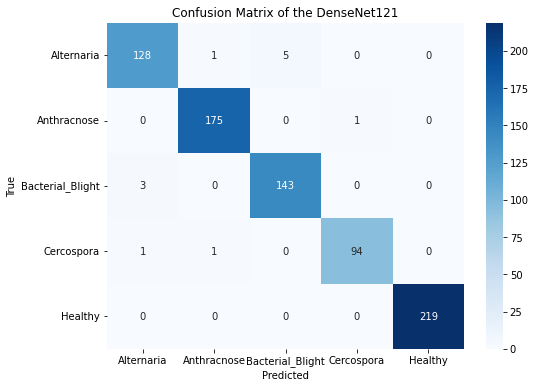

In [23]:
# Ensure the number of true labels matches the number of predictions
if len(test_labels) != len(test_pred_final_classes):
    raise ValueError(f"Number of true labels ({len(test_labels)}) does not match number of predictions ({len(test_pred_final_classes)})")

# Confusion matrix
cm = confusion_matrix(test_labels, test_pred_final_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title(f'Confusion Matrix of the DenseNet121')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

CLASSIFICATION REPORT

In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=categories))

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
                  precision    recall  f1-score   support

      Alternaria       0.97      0.96      0.96       134
     Anthracnose       0.99      0.99      0.99       176
Bacterial_Blight       0.97      0.98      0.97       146
      Cercospora       0.99      0.98      0.98        96
         Healthy       1.00      1.00      1.00       219

        accuracy                           0.98       771
       macro avg       0.98      0.98      0.98       771
    weighted avg       0.98      0.98      0.98       771



SAVING THE MODEL

In [25]:
model.save("EfficientNetV2B0_Model.keras")

# PREDICTION

In [26]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('EfficientNetV2B0_Model.keras')

# Define the class names (should match the classes in the original dataset)
class_names = ['Alternaria', 'Anthracnose', 'Bacterial_Blight', 'Cercospora', 'Healthy']

# Function to preprocess the input image (same as how images are processed in the test generator)
def preprocess_image(image_path, img_size=(224, 224)):
    # Check if the image path is correct and readable
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Convert from BGR (OpenCV) to RGB (used by ImageDataGenerator)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to 224x224 like in ImageDataGenerator
    image = cv2.resize(image, img_size)
    
    # Normalize the image to match rescale=1./255 in the test generator
    image = image.astype('float32') / 255.0
    
    # Add batch dimension (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    return image

# Function to predict the class of a new image
def predict_image_class(image_path, model, class_names):
    image = preprocess_image(image_path)  # Preprocess the image
    prediction = model.predict(image)
    
    # Get the predicted class index and probability distribution
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_names[predicted_class_index]
    return predicted_class, prediction

# Ensure the file path is correct (use this if running on WSL or Linux from Windows paths)
def windows_to_wsl_path(windows_path):
    import subprocess
    return subprocess.check_output(['wslpath', windows_path]).decode('utf-8').strip()

# Path to the new pomegranate image (adjust this to your actual test image path)
# If on WSL, uncomment the following to convert Windows path to WSL path:
image_path = windows_to_wsl_path(r'C:\Users\arock\Downloads\3.jpg')

# Ensure the file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"The image path {image_path} does not exist.")

# Predict and display the result for real-time image
predicted_class, prediction_probabilities = predict_image_class(image_path, model, class_names)
print(f'The predicted class for the real-time image is: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
The predicted class for the real-time image is: Cercospora
